In [ ]:
import pandas as pd
import numpy as np
import sys
sys.path.append("..")  
from openai import OpenAI
import re
from typing import Optional
import matplotlib.pyplot as plt
import os
from dotenv import load_dotenv
load_dotenv()
import csv

In [ ]:
DEEPSEEK_API_KEY = os.getenv("DEEPSEEK_API_KEY")
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

In [ ]:
ACTIVITY = 'activity'
DEVICE = 'device'
START_TIME = 'start_time'
END_TIME = 'end_time'
TIME = 'time'
VALUE = 'value'
NAME = 'name'

DATASET ='B'

# WINDOW_SIZE = "10s"
# STRIDE= "5s"

WINDOW_SIZE = "60s"
STRIDE= "12s"

# WINDOW_SIZE = "30s"
# STRIDE= "6s"

# WINDOW_SIZE = "600s"
# STRIDE= "120s"

# WINDOW_SIZE = "3600s"
# STRIDE= "720s"

# api_key = DEEPSEEK_API_KEY  
# client = OpenAI(api_key=api_key, base_url="https://api.deepseek.com")
# model_name = "deepseek-chat"
# MODEL="deepseek"

api_key = OPENAI_API_KEY
client = OpenAI(api_key=api_key)
model_name="gpt-4o-mini-2024-07-18"
MODEL="gpt-4o-mini"
temperature=0


In [3]:
import sys
sys.path.append("..")  
from data_load.load_data import load_ordoneza_dataset_nochange
from pathlib import Path

dataset_b = load_ordoneza_dataset_nochange(Path("../dataset/UCI_ADL_Binary"), part=DATASET)
print(dataset_b['activities'].head())
print(dataset_b['devices'].head())
print(dataset_b.keys())
print(dataset_b['activity_list'])

Corrections applied to OrdonezB activities:
Adjusted Toileting end from 2012-11-14 00:29:59 to 2012-11-14 00:29:00 due to overlap with Sleeping
Adjusted Spare_Time/TV end from 2012-11-14 12:52:59 to 2012-11-14 12:52:00 due to overlap with Leaving
Adjusted Spare_Time/TV end from 2012-11-14 21:37:59 to 2012-11-14 21:37:00 due to overlap with Dinner
Adjusted Spare_Time/TV end from 2012-11-14 22:14:59 to 2012-11-14 22:14:00 due to overlap with Snack
Adjusted Sleeping start from 2012-11-15 00:10:00 to 2012-11-15 00:10:59 due to overlap with Grooming
Adjusted Sleeping end from 2012-11-15 00:43:59 to 2012-11-15 00:43:00 due to overlap with Spare_Time/TV
Adjusted Spare_Time/TV end from 2012-11-17 20:26:59 to 2012-11-17 20:26:00 due to overlap with Snack
Adjusted Spare_Time/TV end from 2012-11-19 21:59:59 to 2012-11-19 21:59:00 due to overlap with Dinner
Adjusted Snack end from 2012-11-19 22:32:59 to 2012-11-19 22:32:00 due to overlap with Spare_Time/TV
Adjusted Leaving end from 2012-11-22 01:4

In [4]:
import pandas as pd
from io import StringIO

def convert_events_to_states(event_df):
    """
    将二值传感器事件流转换为传感器状态流，适配特定传感器列表，并包含位置信息。
    
    参数:
    event_df: DataFrame 包含 Start time, End time, Location, Type, Place 列
    
    返回:
    DataFrame 包含状态的开始时间、结束时间和状态描述
    """
    # 创建空的列表来存储状态
    states = []
    
    # 确保时间列是 datetime 类型
    event_df['start_time'] = pd.to_datetime(event_df['start_time'])
    event_df['end_time'] = pd.to_datetime(event_df['end_time'])

    # 清除 location 和 place 列的空格并删除 NaN 行
    event_df['location'] = event_df['location'].str.strip()
    event_df['place'] = event_df['place'].str.strip()
    event_df.dropna(subset=['location', 'place'], inplace=True)
    
    # 定义传感器类型到状态的映射
    state_mappings = {
        'PIR': {
            'Door': {'Living': 'NearLivingArea', 'Kitchen': 'NearKitchenArea', 'Bedroom': 'NearBedroomArea', 'Bathroom': 'NearBathroomArea'},
            'Basin': {'Bathroom': 'NearBathroomBasin'},
            'Shower': {'Bathroom': 'NearBathroomShower'},
        },
        'Magnetic': {
            'Fridge': {'Kitchen': 'FridgeDoorOpen'},
            'Cupboard': {'Kitchen': 'CupboardDoorOpen'},
            'Maindoor': {'Entrance': 'MainDoorOpen'},
        },
        'Flush': {
            'Toilet': {'Toilet': 'ToiletFlushing'}
        },
        'Pressure': {
            'Seat': {'Living': 'SeatOccupied'},
            'Bed': {'Bedroom': 'BedOccupied'}
        },
        'Electric': {
            'Microwave': {'Kitchen': 'MicrowaveOn'}
        }
    }
    
    # 对每一行进行处理
    for index, row in event_df.iterrows():
        # 获取传感器类型和位置
        sensor_type = row['type']
        location = row['location']
        place = row['place']
        
        # 根据传感器类型和位置生成状态名称
        if sensor_type in state_mappings and location in state_mappings[sensor_type] and place in state_mappings[sensor_type][location]:
            state_name = state_mappings[sensor_type][location][place]
        else:
            # 默认情况：使用 Location + Type
            state_name = f"{location}{sensor_type}"
        
        # 创建状态描述，格式为 st(state_name, start_time, end_time)
        state_desc = f"st({place}-{state_name}, {row['start_time'].strftime('%H:%M')}, {row['end_time'].strftime('%H:%M')})"
        
        # 添加到状态列表
        states.append({
            'state': state_desc,
            'start_time': row['start_time'],
            'end_time': row['end_time'],
            'location': row['location'],
            'type': row['type'],
            'place': row['place'],
            'device': row['device']
        })
    
    # 创建结果 DataFrame
    result_df = pd.DataFrame(states)
    
    # 按时间排序
    result_df = result_df.sort_values('start_time')
    
    return result_df


# 转换事件到状态
state_df = convert_events_to_states(dataset_b['devices'])

# 打印结果
print(state_df)
# state_df.head(40)

                                          state          start_time  \
0         st(Living-SeatOccupied, 21:14, 00:21) 2012-11-11 21:14:21   
1       st(Living-NearLivingArea, 00:22, 00:22) 2012-11-12 00:22:57   
2     st(Kitchen-NearKitchenArea, 00:23, 00:23) 2012-11-12 00:23:14   
3     st(Kitchen-NearKitchenArea, 00:24, 00:24) 2012-11-12 00:24:20   
4       st(Living-NearLivingArea, 00:24, 00:24) 2012-11-12 00:24:42   
...                                         ...                 ...   
2329  st(Bedroom-NearBedroomArea, 20:41, 20:41) 2012-12-02 20:41:25   
2330    st(Living-NearLivingArea, 20:41, 20:41) 2012-12-02 20:41:44   
2331    st(Living-NearLivingArea, 21:18, 21:18) 2012-12-02 21:18:10   
2332    st(Living-NearLivingArea, 21:18, 21:18) 2012-12-02 21:18:28   
2333      st(Living-SeatOccupied, 21:19, 01:03) 2012-12-02 21:19:12   

                end_time location      type    place                device  
0    2012-11-12 00:21:49     Seat  Pressure   Living  Living_Seat_Pres

In [5]:
states_df=convert_events_to_states(dataset_b['devices'])

In [6]:
states_df
states_df['date'] = states_df['start_time'].dt.date

# 3. 计算最早的日期
earliest_date = states_df['date'].min()

# 4. 计算 14 天后的日期
fourteen_days_later = earliest_date + pd.Timedelta(days=14)

# 5. 筛选 DataFrame
df_14_days = states_df[states_df['date'] <= fourteen_days_later]

# 打印结果
print(df_14_days)

                                          state          start_time  \
0         st(Living-SeatOccupied, 21:14, 00:21) 2012-11-11 21:14:21   
1       st(Living-NearLivingArea, 00:22, 00:22) 2012-11-12 00:22:57   
2     st(Kitchen-NearKitchenArea, 00:23, 00:23) 2012-11-12 00:23:14   
3     st(Kitchen-NearKitchenArea, 00:24, 00:24) 2012-11-12 00:24:20   
4       st(Living-NearLivingArea, 00:24, 00:24) 2012-11-12 00:24:42   
...                                         ...                 ...   
1507    st(Living-NearLivingArea, 23:22, 23:22) 2012-11-25 23:22:22   
1508  st(Kitchen-NearKitchenArea, 23:22, 23:22) 2012-11-25 23:22:33   
1509  st(Kitchen-NearKitchenArea, 23:25, 23:25) 2012-11-25 23:25:21   
1510    st(Living-NearLivingArea, 23:25, 23:25) 2012-11-25 23:25:34   
1511      st(Living-SeatOccupied, 23:26, 00:21) 2012-11-25 23:26:17   

                end_time location      type    place                device  \
0    2012-11-12 00:21:49     Seat  Pressure   Living  Living_Seat_Pre

In [7]:
def align_sensors_with_activities(sensor_df, activity_df):
    sensor_df['activity'] = None
    for i, sensor_row in sensor_df.iterrows():
        for j, activity_row in activity_df.iterrows():
            # 检查时间重叠
            if (sensor_row['start_time'] <= activity_row['end_time'] and 
                sensor_row['end_time'] >= activity_row['start_time']):
                sensor_df.at[i, 'activity'] = activity_row['activity']
                break  # 找到匹配后跳出内层循环
    return sensor_df

In [8]:
aligned_df=align_sensors_with_activities(df_14_days, dataset_b['activities'])
aligned_df=aligned_df.dropna()
print(aligned_df)

# empty_activity_rows = aligned_df[aligned_df['activity'].isnull()]
# print(empty_activity_rows)

C:\Users\leave\AppData\Local\Temp\ipykernel_39744\1542133342.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sensor_df['activity'] = None


                                          state          start_time  \
0         st(Living-SeatOccupied, 21:14, 00:21) 2012-11-11 21:14:21   
1       st(Living-NearLivingArea, 00:22, 00:22) 2012-11-12 00:22:57   
3     st(Kitchen-NearKitchenArea, 00:24, 00:24) 2012-11-12 00:24:20   
4       st(Living-NearLivingArea, 00:24, 00:24) 2012-11-12 00:24:42   
5         st(Living-SeatOccupied, 00:25, 00:42) 2012-11-12 00:25:35   
...                                         ...                 ...   
1502      st(Living-SeatOccupied, 22:15, 23:19) 2012-11-25 22:15:01   
1503    st(Living-NearLivingArea, 23:20, 23:20) 2012-11-25 23:20:05   
1504  st(Kitchen-NearKitchenArea, 23:20, 23:20) 2012-11-25 23:20:18   
1510    st(Living-NearLivingArea, 23:25, 23:25) 2012-11-25 23:25:34   
1511      st(Living-SeatOccupied, 23:26, 00:21) 2012-11-25 23:26:17   

                end_time location      type    place                device  \
0    2012-11-12 00:21:49     Seat  Pressure   Living  Living_Seat_Pre

In [11]:
def segment_by_time_with_status_hci(X: pd.DataFrame, y: pd.DataFrame = None, window_size: str = '60s', 
                                    stride: str = None, time_col: str = 'start_time', 
                                    end_time_col: str = 'end_time', activity_col: str = 'activity',
                                    drop_empty_intervals: bool = True) -> tuple:
    """
    按时间窗口分割状态流数据，支持状态的截断，优化性能。
    
    参数:
    X: pd.DataFrame, 状态流数据，包含 start_time 和 end_time 列
    y: pd.DataFrame, 可选，标签数据
    window_size: str, 窗口大小，例如 '60s'
    stride: str, 步长，例如 '12s'
    time_col: str, 开始时间列名，默认为 'start_time'
    end_time_col: str, 结束时间列名，默认为 'end_time'
    activity_col: str, 活动列名，默认为 'activity'
    drop_empty_intervals: bool, 是否丢弃空窗口
    
    返回:
    tuple: (X_list, y_list) 或 (X_list, None)，X_list 是按窗口分割的状态流片段列表
    """
    # 输入校验
    if not isinstance(X, pd.DataFrame):
        raise ValueError("X 必须是 pandas.DataFrame 类型")
    if y is not None and not isinstance(y, pd.DataFrame):
        raise ValueError("y 如果提供，必须是 pandas.DataFrame 类型")
    if time_col not in X.columns or end_time_col not in X.columns:
        raise ValueError(f"X 中必须包含开始时间列 '{time_col}' 和结束时间列 '{end_time_col}'")
    if y is not None and (time_col not in y.columns or activity_col not in y.columns):
        raise ValueError(f"y 中必须包含时间列 '{time_col}' 和活动列 '{activity_col}'")

    # 转换为 Timedelta
    window_size = pd.Timedelta(window_size)
    if stride is None:
        stride = window_size
    else:
        if isinstance(stride, str) and '*' in stride:
            time_part, multiplier_part = stride.split('*')
            time_delta = pd.Timedelta(time_part)
            multiplier = float(multiplier_part)
            stride = time_delta * multiplier
        else:
            stride = pd.Timedelta(stride)

    # 确保时间列是 datetime 类型并排序
    df = X.copy()
    df[time_col] = pd.to_datetime(df[time_col])
    df[end_time_col] = pd.to_datetime(df[end_time_col])
    df = df.sort_values(by=time_col)

    # 计算时间范围
    st = df[time_col].iloc[0] - pd.Timedelta('1s')
    et = df[end_time_col].iloc[-1] + pd.Timedelta('1s')
    st_windows = pd.date_range(st, et - window_size, freq=stride)
    
    # 预计算窗口边界
    window_starts = pd.Series(st_windows)
    window_ends = window_starts + window_size

    # 初始化结果列表
    X_list = []
    y_list = []

    # 为状态流创建时间数组
    state_starts = df[time_col]
    state_ends = df[end_time_col]

    # 向量化查找重叠状态
    for i, (win_st, win_et) in enumerate(zip(window_starts, window_ends)):
        # 找到与窗口重叠的状态
        overlap_mask = (state_starts < win_et) & (state_ends > win_st)
        overlapping_states = df[overlap_mask].copy()
        
        if not overlapping_states.empty or not drop_empty_intervals:
            # 计算窗口内的状态片段，使用 Pandas 的 clip 方法
            overlapping_states[time_col] = overlapping_states[time_col].clip(lower=win_st)
            overlapping_states[end_time_col] = overlapping_states[end_time_col].clip(upper=win_et)
            
            # 添加到结果列表
            X_list.append(overlapping_states)
            
            # 处理标签数据
            if y is not None:
                y_segment = y[(y[time_col] >= win_st) & (y[time_col] < win_et)].copy()
                y_list.append(y_segment)

    # 返回结果
    if y is not None:
        return X_list, y_list
    else:
        return X_list, None


# 运行函数
windows, labels = segment_by_time_with_status_hci(
    X=aligned_df,
    window_size=WINDOW_SIZE,
    # stride=STRIDE,
    time_col='start_time',
    end_time_col='end_time'
)

# 打印前几个窗口
for i, window in enumerate(windows[:5]):
    print(f"窗口 {i}:")
    print(window)
    print()

窗口 0:
                                   state          start_time  \
0  st(Living-SeatOccupied, 21:14, 00:21) 2012-11-11 21:14:21   

             end_time location      type   place                device  \
0 2012-11-11 21:15:20     Seat  Pressure  Living  Living_Seat_Pressure   

         date           activity  
0  2012-11-11  relaxing on couch  

窗口 1:
                                   state          start_time  \
0  st(Living-SeatOccupied, 21:14, 00:21) 2012-11-11 21:15:20   

             end_time location      type   place                device  \
0 2012-11-11 21:16:20     Seat  Pressure  Living  Living_Seat_Pressure   

         date           activity  
0  2012-11-11  relaxing on couch  

窗口 2:
                                   state          start_time  \
0  st(Living-SeatOccupied, 21:14, 00:21) 2012-11-11 21:16:20   

             end_time location      type   place                device  \
0 2012-11-11 21:17:20     Seat  Pressure  Living  Living_Seat_Pressure   

      

In [12]:
len(windows)

13167

In [13]:
import pandas as pd

def remove_duplicate_windows(dataframes):
    if not dataframes:
        return []

    result = [dataframes[0]]  # 初始化结果列表，包含第一个窗口
    count = 1  # 初始化计数器

    for i in range(1, len(dataframes)):
        prev_window = result[-1]
        current_window = dataframes[i]

        # 检查 device 和 state 是否相同
        if (
            prev_window['device'].iloc[0] == current_window['device'].iloc[0]
            and prev_window['state'].iloc[0] == current_window['state'].iloc[0]
        ):
            count += 1
            if count <= 3:
                result.append(current_window)
        else:
            count = 1  # 重置计数器
            result.append(current_window)

    return result

processed_dataframes = remove_duplicate_windows(windows)

# 打印处理后的 DataFrame 列表（可选）
if processed_dataframes:
    for i, df in enumerate(processed_dataframes):
        print(f"窗口 {i + 1}:")
        print(df)
        print("-" * 20)

窗口 1:
                                   state          start_time  \
0  st(Living-SeatOccupied, 21:14, 00:21) 2012-11-11 21:14:21   

             end_time location      type   place                device  \
0 2012-11-11 21:15:20     Seat  Pressure  Living  Living_Seat_Pressure   

         date           activity  
0  2012-11-11  relaxing on couch  
--------------------
窗口 2:
                                   state          start_time  \
0  st(Living-SeatOccupied, 21:14, 00:21) 2012-11-11 21:15:20   

             end_time location      type   place                device  \
0 2012-11-11 21:16:20     Seat  Pressure  Living  Living_Seat_Pressure   

         date           activity  
0  2012-11-11  relaxing on couch  
--------------------
窗口 3:
                                   state          start_time  \
0  st(Living-SeatOccupied, 21:14, 00:21) 2012-11-11 21:16:20   

             end_time location      type   place                device  \
0 2012-11-11 21:17:20     Seat  Pressure 

In [14]:
import os
import pandas as pd

def save_dataframes_to_files(dataframes, folder_path=f'LLM_{MODEL}_{DATASET}_{WINDOW_SIZE}/window_dataframes_{DATASET}_{WINDOW_SIZE}', 
                             truth_labels_path=f'LLM_{MODEL}_{DATASET}_{WINDOW_SIZE}/truth_labels_{DATASET}_{WINDOW_SIZE}.txt'):
    """
    将 DataFrame 列表中的每个 DataFrame 存储到单独的文件中，并将所有文件放入指定文件夹中。
    在移除 'activity' 列之前，提取所有唯一的 'activity' 信息，并以逗号分隔的形式保存到 truth_labels.txt 文件中。

    参数：
    dataframes (list): DataFrame 列表。
    folder_path (str): 存储文件的文件夹路径。
    truth_labels_path (str): 存储真实标签的文件路径。
    """

    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

    activity_labels = []  # 用于存储 activity 标签的列表

    for i, df in enumerate(dataframes):
        if 'activity' in df.columns:
            # 提取所有唯一的 activity 信息
            unique_activities = ','.join(df['activity'].unique().tolist())
            activity_labels.append(unique_activities)

            # 删除 'activity' 列
            df = df.drop(columns=['activity'])

        file_name = f'window_{i + 1}.csv'
        file_path = os.path.join(folder_path, file_name)
        df.to_csv(file_path, index=False)
        print(f'DataFrame {i + 1} 已保存到 {file_path} (已移除 activity 列)')

    # 将 activity 标签写入文件
    with open(truth_labels_path, 'w') as f:
        for item in activity_labels:
            f.write("%s\n" % item)
    print(f"Activity 标签已保存到 {truth_labels_path}")

# 假设 processed_dataframes 已经定义
save_dataframes_to_files(processed_dataframes)

DataFrame 1 已保存到 LLM_gpt-4o-mini_B_60s/window_dataframes_B_60s\window_1.csv (已移除 activity 列)
DataFrame 2 已保存到 LLM_gpt-4o-mini_B_60s/window_dataframes_B_60s\window_2.csv (已移除 activity 列)
DataFrame 3 已保存到 LLM_gpt-4o-mini_B_60s/window_dataframes_B_60s\window_3.csv (已移除 activity 列)
DataFrame 4 已保存到 LLM_gpt-4o-mini_B_60s/window_dataframes_B_60s\window_4.csv (已移除 activity 列)
DataFrame 5 已保存到 LLM_gpt-4o-mini_B_60s/window_dataframes_B_60s\window_5.csv (已移除 activity 列)
DataFrame 6 已保存到 LLM_gpt-4o-mini_B_60s/window_dataframes_B_60s\window_6.csv (已移除 activity 列)
DataFrame 7 已保存到 LLM_gpt-4o-mini_B_60s/window_dataframes_B_60s\window_7.csv (已移除 activity 列)
DataFrame 8 已保存到 LLM_gpt-4o-mini_B_60s/window_dataframes_B_60s\window_8.csv (已移除 activity 列)
DataFrame 9 已保存到 LLM_gpt-4o-mini_B_60s/window_dataframes_B_60s\window_9.csv (已移除 activity 列)
DataFrame 10 已保存到 LLM_gpt-4o-mini_B_60s/window_dataframes_B_60s\window_10.csv (已移除 activity 列)
DataFrame 11 已保存到 LLM_gpt-4o-mini_B_60s/window_dataframes_B_60s\wind

In [15]:
import os
import pandas as pd
from pathlib import Path
import re

def load_dataframes_from_files(folder_path=f'LLM_{MODEL}_{DATASET}_{WINDOW_SIZE}/window_dataframes_{DATASET}_{WINDOW_SIZE}'):
    """
    从指定文件夹加载所有窗口文件，并按数字顺序返回 DataFrame 列表。
    """
    dataframes = []
    folder = Path(folder_path)

    if folder.exists():
        files = list(folder.glob('window_*.csv'))  # 获取所有窗口文件列表

        # 使用正则表达式提取文件名中的数字，并进行排序
        def get_window_number(file_path):
            match = re.search(r'window_(\d+)\.csv', str(file_path))
            return int(match.group(1)) if match else 0

        sorted_files = sorted(files, key=get_window_number)

        for file_path in sorted_files:
            try:
                df = pd.read_csv(file_path)
                dataframes.append(df)
            except Exception as e:
                print(f"警告：加载文件 {file_path} 时出错：{e}")
    else:
        print(f"警告：文件夹 {folder_path} 不存在。")

    return dataframes

# 加载 DataFrame
loaded_dataframes = load_dataframes_from_files()

# 打印前五个加载的 DataFrame（可选）
if loaded_dataframes:
    for i, df in enumerate(loaded_dataframes):
        if i < 5: 
            print(f"DataFrame {i + 1}:")
            print(df.head())
            print("-" * 20)
        else:
            break  # 停止循环

DataFrame 1:
                                   state           start_time  \
0  st(Living-SeatOccupied, 21:14, 00:21)  2012-11-11 21:14:21   

              end_time location      type   place                device  \
0  2012-11-11 21:15:20     Seat  Pressure  Living  Living_Seat_Pressure   

         date  
0  2012-11-11  
--------------------
DataFrame 2:
                                   state           start_time  \
0  st(Living-SeatOccupied, 21:14, 00:21)  2012-11-11 21:15:20   

              end_time location      type   place                device  \
0  2012-11-11 21:16:20     Seat  Pressure  Living  Living_Seat_Pressure   

         date  
0  2012-11-11  
--------------------
DataFrame 3:
                                   state           start_time  \
0  st(Living-SeatOccupied, 21:14, 00:21)  2012-11-11 21:16:20   

              end_time location      type   place                device  \
0  2012-11-11 21:17:20     Seat  Pressure  Living  Living_Seat_Pressure   

         


    The data comes from a 60s-second time window around 9:14 PM.
    The home has the following locations: 'bathroom', 'bedroom', 'kitchen', and 'living room','main entrance(only with main foor)'.
    Here is the list of recorded events:
    [{'state': 'Living-SeatOccupied', 'place': 'living', 'duration': 59}]
    
    Please generate a natural language description based on these events, following these guidelines:
    - Start with "Around 9:14 PM, ".
    - Indicate the subject's location (place) and describe their activities.
    - Use connecting words (like "then" or "while") to make the description flow smoothly.
    
Window 1:
Description: Around 9:14 PM, the subject was in the living room, where they occupied the seat for nearly a minute. During this time, they likely engaged in some relaxing activities, perhaps watching television or reading a book.
Classified Activity: relaxing on couch
Description Time: 2.01s, Tokens: 228
Classification Time: 0.89s, Tokens: 314


    The data 

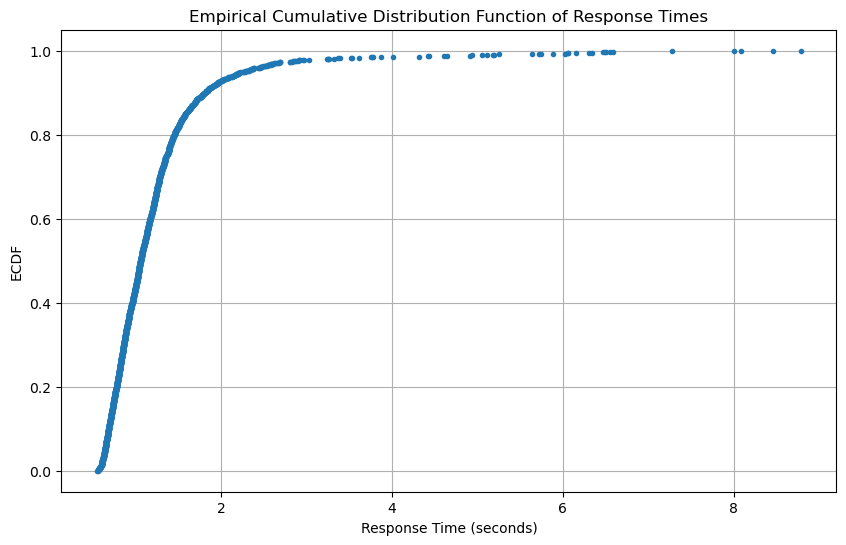

ECDF plot saved to: LLM_gpt-4o-mini_B_60s/response_time_ecdf.png


In [16]:
import pandas as pd
from datetime import timedelta
import time
import matplotlib.pyplot as plt
import numpy as np
from typing import Optional
import re
import os

# Function 1: Generate natural language descriptions with token and time tracking
def generate_natural_language_description(df, window_size=WINDOW_SIZE):
    """
    Convert sensor state data into a natural language description using LLM.
    Tracks token usage and response time.
    """
    df['start_time'] = pd.to_datetime(df['start_time'])
    df['end_time'] = pd.to_datetime(df['end_time'])
    
    window_start = df['start_time'].min()
    # window_end = window_start + timedelta(seconds=window_size)
    window_time_str = window_start.strftime('%I:%M %p').lstrip('0')
    
    df = df.sort_values('start_time')
    
    events = []
    for _, row in df.iterrows():
        state_name = row['state'].split('(')[1].split(',')[0]
        duration = (row['end_time'] - row['start_time']).total_seconds()
        event = {
            'state': state_name,
            # 'location': row['location'].lower(),
            'place': row['place'].lower(),
            'duration': int(duration) if duration > 0 else 1
        }
        events.append(event)
    
    prompt = f"""
    The data comes from a {window_size}-second time window around {window_time_str}.
    The home has the following locations: 'bathroom', 'bedroom', 'kitchen', and 'living room','main entrance(only with main foor)'.
    Here is the list of recorded events:
    {events}
    
    Please generate a natural language description based on these events, following these guidelines:
    - Start with "Around {window_time_str}, ".
    - Indicate the subject's location (place) and describe their activities.
    - Use connecting words (like "then" or "while") to make the description flow smoothly.
    """

    print(prompt)
    
    try:
        start_time = time.time()
        response = client.chat.completions.create(
            model=model_name,
            messages=[
                {"role": "system", "content": "You are an helpful intelligent assistant tasked with converting sensor data into smooth, natural English descriptions"},
                {"role": "user", "content": prompt}
            ],
            max_tokens=500,
            temperature=0.0
        )
        end_time = time.time()
        
        response_time = end_time - start_time
        tokens_used = response.usage.total_tokens if hasattr(response, 'usage') else 0
        
        return {
            'description': response.choices[0].message.content.strip(),
            'response_time': response_time,
            'tokens_used': tokens_used
        }
    except Exception as e:
        return {
            'description': f"Error generating description: {str(e)}",
            'response_time': 0,
            'tokens_used': 0
        }

# Function 2: Classify a single description with token and time tracking
def classify_single_activity(description):


    system_prompt = """
    Act as a human activity recognition system that infers the activities performed by a subject in their home.
    The home has the following locations: 'bathroom', 'bedroom', 'kitchen', 'living room', and 'main entrance (main door)'. Each room has its own door, and the house's main door is referred to as the 'main door'.    
    The system captures the subject's interactions with: Shower, Basin, Maindoor, Fridge, Cupboard, Toilet, Microwave, Seat, Bed.
    I will provide you with a description of what happened during a specific time window, and your goal is to provide the most likely activity.
    **Important Rule:** 
    The 'leaving home' activity should ONLY be inferred when the 'Maindoor' sensor is triggered and no other activities are strongly indicated by other sensors.
    The possible activities are: sleeping,showering,preparing breakfast,personal care,relaxing on couch,leaving home,preparing lunch,snacking,,preparing dinner
    Your answer should be one or more of these activities using the following format: ACTIVITY=(activity name) or ACTIVITY=(activity name,activity name)
    """
    
    try:
        start_time = time.time()
        response = client.chat.completions.create(
            model=model_name,
            messages=[
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": description}
            ],
            stream=False,
            temperature=0.0
        )
        end_time = time.time()
        
        response_time = end_time - start_time
        tokens_used = response.usage.total_tokens if hasattr(response, 'usage') else 0
        
        activity_str = response.choices[0].message.content.strip()
        activity_label = extract_activity_label(activity_str)
        
        return {
            'activity': activity_label if activity_label else "Unknown",
            'response_time': response_time,
            'tokens_used': tokens_used
        }
    except Exception as e:
        return {
            'activity': f"Error: {str(e)}",
            'response_time': 0,
            'tokens_used': 0
        }

# Helper function to extract activity label
def extract_activity_label(response: str) -> Optional[str]:
    """Extract the activity label from the model response."""
    match = re.search(r"ACTIVITY=(.*)", response)
    if match:
        return match.group(1).strip()
    return None

# Modified pipeline execution with tracking and ECDF plotting
def run_pipeline(windows, desc_output_path=f'LLM_{MODEL}_{DATASET}_{WINDOW_SIZE}/descriptions_{DATASET}_{WINDOW_SIZE}.txt', 
                 label_output_path=f'LLM_{MODEL}_{DATASET}_{WINDOW_SIZE}/predictions_{DATASET}_{WINDOW_SIZE}.txt',
                 metrics_output_path=f'LLM_{MODEL}_{DATASET}_{WINDOW_SIZE}/metrics_{DATASET}_{WINDOW_SIZE}.txt'):
    """
    Run the pipeline: generate description, classify it, track metrics, and plot ECDF of response times.
    """
    os.makedirs(os.path.dirname(desc_output_path), exist_ok=True)
    
    response_times = []
    total_tokens = 0
    all_tokens = []

    with open(desc_output_path, 'w', encoding='utf-8') as desc_file, \
         open(label_output_path, 'w', encoding='utf-8') as label_file, \
         open(metrics_output_path, 'w', encoding='utf-8') as metrics_file:
        
        for idx, window in enumerate(windows):
            # Step 1: Generate description
            desc_result = generate_natural_language_description(window)
            description = desc_result['description']
            desc_time = desc_result['response_time']
            desc_tokens = desc_result['tokens_used']
            
            # Step 2: Classify the description
            class_result = classify_single_activity(description)
            activity_label = class_result['activity']
            class_time = class_result['response_time']
            class_tokens = class_result['tokens_used']
            
            # Track metrics
            response_times.extend([desc_time, class_time])
            total_tokens += desc_tokens + class_tokens
            all_tokens.extend([desc_tokens, class_tokens])

            # Print results
            print(f"Window {idx + 1}:")
            print(f"Description: {description}")
            print(f"Classified Activity: {activity_label}")
            print(f"Description Time: {desc_time:.2f}s, Tokens: {desc_tokens}")
            print(f"Classification Time: {class_time:.2f}s, Tokens: {class_tokens}\n")
            
            # Save to files
            desc_file.write(f"{description}\n")
            label_file.write(f"{activity_label}\n")
            metrics_file.write(f"Window {idx + 1}:\n")
            metrics_file.write(f"Description Time: {desc_time:.2f}s, Tokens: {desc_tokens}\n")
            metrics_file.write(f"Classification Time: {class_time:.2f}s, Tokens: {class_tokens}\n\n")

        print(f"\nTotal windows processed: {len(windows)}")
        print(f"Total tokens used: {total_tokens}")
        print(f"Descriptions saved to: {desc_output_path}")
        print(f"Activity labels saved to: {label_output_path}")
        print(f"Metrics saved to: {metrics_output_path}") # 添加了metrics的保存路径输出

        # Save all tokens to the metrics file
        # metrics_file.write("\nAll tokens used (description, classification):\n")
        # for tokens in all_tokens:
        #     metrics_file.write(f"{tokens}\n")

    # Generate and plot ECDF
    plot_ecdf(response_times)

def plot_ecdf(response_times):
    """Generate and display ECDF plot of response times."""
    sorted_times = np.sort(response_times)
    y = np.arange(1, len(sorted_times) + 1) / len(sorted_times)
    
    plt.figure(figsize=(10, 6))
    plt.plot(sorted_times, y, marker='.', linestyle='none')
    plt.xlabel('Response Time (seconds)')
    plt.ylabel('ECDF')
    plt.title('Empirical Cumulative Distribution Function of Response Times')
    plt.grid(True)
    
    # Save plot
    plot_path = f'LLM_{MODEL}_{DATASET}_{WINDOW_SIZE}/response_time_ecdf.png'
    os.makedirs(os.path.dirname(plot_path), exist_ok=True)
    plt.savefig(plot_path)
    plt.show()
    print(f"ECDF plot saved to: {plot_path}")

# Run the pipeline
test = loaded_dataframes.copy()
run_pipeline(test)

In [8]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import os
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_predictions_split_activities(true_labels_file, predicted_labels_file, output_file=f'LLM_{MODEL}_{DATASET}_{WINDOW_SIZE}/evaluation_{DATASET}_{WINDOW_SIZE}.txt'):
    """
    评估预测标签，拆分窗口中的多个活动，并输出每个类别的 F1 分数和混淆矩阵图像。
    """
    try:
        with open(true_labels_file, 'r') as f:
            true_labels_raw = [line.strip() for line in f]

        with open(predicted_labels_file, 'r') as f:
            predicted_labels_raw = [line.strip() for line in f]

        if len(true_labels_raw) != len(predicted_labels_raw):
            raise ValueError("真实标签的数量与预测标签的数量不匹配。")

        true_labels_split = [label.split(',') for label in true_labels_raw]
        predicted_labels_split = [label.split(',') for label in predicted_labels_raw]

        true_labels_split = [[label.strip() for label in sublist] for sublist in true_labels_split]
        predicted_labels_split = [[label.strip() for label in sublist] for sublist in predicted_labels_split]

        all_true_labels = []
        all_predicted_labels = []

        for true_labels, predicted_labels in zip(true_labels_split, predicted_labels_split):
            all_true_labels.extend(true_labels)
            all_predicted_labels.extend(predicted_labels)

        unique_labels = sorted(list(set(all_true_labels + all_predicted_labels)))

        y_true = []
        y_pred = []

        for true_labels, predicted_labels in zip(true_labels_split, predicted_labels_split):
            temp_true = []
            temp_pred = []
            for label in unique_labels:
                if label in true_labels:
                    temp_true.append(1)
                else:
                    temp_true.append(0)
                if label in predicted_labels:
                    temp_pred.append(1)
                else:
                    temp_pred.append(0)
            y_true.append(temp_true)
            y_pred.append(temp_pred)

        y_true = np.array(y_true)
        y_pred = np.array(y_pred)

        cm = confusion_matrix(y_true.argmax(axis=1), y_pred.argmax(axis=1))
        cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # 归一化混淆矩阵

        with open(output_file, 'w') as output:
            output.write("Classification Report:\n")
            output.write(classification_report(y_true, y_pred, target_names=unique_labels))

            output.write("\nConfusion Matrix:\n")
            output.write(np.array2string(cm))

            f1_macro = f1_score(y_true, y_pred, average='macro')
            output.write(f"\nF1 Macro Score: {f1_macro}\n")

            f1_per_class = f1_score(y_true, y_pred, average=None)
            output.write("\nF1 Score per Class:\n")
            for i, label in enumerate(unique_labels):
                output.write(f"  {label}: {f1_per_class[i]}\n")

        # 绘制混淆矩阵图像
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues", xticklabels=unique_labels, yticklabels=unique_labels)
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.title('Normalized Confusion Matrix')
        plt.tight_layout()

        # 保存混淆矩阵图像
        plot_path = f'LLM_{MODEL}_{DATASET}_{WINDOW_SIZE}/confusion_matrix_{DATASET}_{WINDOW_SIZE}.png'
        os.makedirs(os.path.dirname(plot_path), exist_ok=True)
        plt.savefig(plot_path)
        plt.close()

        print(f"拆分活动后的评估结果已保存到 {output_file} 和 {plot_path}")

    except FileNotFoundError:
        print("Error: 文件未找到。")
    except ValueError as e:
        print(f"Error: {e}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

# 示例用法
true_labels_file = f'LLM_{MODEL}_{DATASET}_{WINDOW_SIZE}/truth_labels_{DATASET}_{WINDOW_SIZE}.txt'
predicted_labels_file = f'LLM_{MODEL}_{DATASET}_{WINDOW_SIZE}/predictions_{DATASET}_{WINDOW_SIZE}.txt'
output_file = f'LLM_{MODEL}_{DATASET}_{WINDOW_SIZE}/output_{DATASET}_{WINDOW_SIZE}.txt'

evaluate_predictions_split_activities(true_labels_file, predicted_labels_file, output_file)

拆分活动后的评估结果已保存到 LLM_gpt-4o-mini_B_60s/output_B_60s.txt 和 LLM_gpt-4o-mini_B_60s/confusion_matrix_B_60s.png


In [6]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import os
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_predictions_split_activities(true_labels_file, predicted_labels_file, output_file=f'LLM_{MODEL}_{DATASET}_{WINDOW_SIZE}/evaluation_{DATASET}_{WINDOW_SIZE}.txt'):
    """
    评估预测标签，拆分窗口中的多个活动，并输出每个类别的 F1 分数和混淆矩阵图像。
    """
    try:
        with open(true_labels_file, 'r') as f:
            true_labels_raw = [line.strip() for line in f]

        with open(predicted_labels_file, 'r') as f:
            predicted_labels_raw = [line.strip() for line in f]

        if len(true_labels_raw) != len(predicted_labels_raw):
            raise ValueError("真实标签的数量与预测标签的数量不匹配。")

        true_labels_split = [label.split(',') for label in true_labels_raw]
        predicted_labels_split = [label.split(',') for label in predicted_labels_raw]

        true_labels_split = [[label.strip() for label in sublist] for sublist in true_labels_split]
        predicted_labels_split = [[label.strip() for label in sublist] for sublist in predicted_labels_split]

        all_true_labels = []
        all_predicted_labels = []

        for true_labels, predicted_labels in zip(true_labels_split, predicted_labels_split):
            all_true_labels.extend(true_labels)
            all_predicted_labels.extend(predicted_labels)

        unique_labels = sorted(list(set(all_true_labels + all_predicted_labels)))

        y_true = []
        y_pred = []

        for true_labels, predicted_labels in zip(true_labels_split, predicted_labels_split):
            temp_true = []
            temp_pred = []
            for label in unique_labels:
                if label in true_labels:
                    temp_true.append(1)
                else:
                    temp_true.append(0)
                # 修改标签比较逻辑
                if label in predicted_labels:
                    temp_pred.append(1)
                else:
                    temp_pred.append(0)
            y_true.append(temp_true)
            y_pred.append(temp_pred)

        y_true = np.array(y_true)
        y_pred = np.array(y_pred)

        # 修改混淆矩阵计算逻辑
        true_labels_single = []
        predicted_labels_single = []
        for i in range(len(y_true)):
            true_labels_single.append(np.argmax(y_true[i]))
            predicted_labels_single.append(np.argmax(y_pred[i]))

        cm = confusion_matrix(true_labels_single, predicted_labels_single)
        cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # 归一化混淆矩阵

        with open(output_file, 'w') as output:
            output.write("Classification Report:\n")
            output.write(classification_report(true_labels_single, predicted_labels_single, target_names=unique_labels))

            output.write("\nConfusion Matrix:\n")
            output.write(np.array2string(cm))

            f1_macro = f1_score(true_labels_single, predicted_labels_single, average='macro')
            output.write(f"\nF1 Macro Score: {f1_macro}\n")

            f1_per_class = f1_score(true_labels_single, predicted_labels_single, average=None)
            output.write("\nF1 Score per Class:\n")
            for i, label in enumerate(unique_labels):
                output.write(f"  {label}: {f1_per_class[i]}\n")

        # 绘制混淆矩阵图像
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues", xticklabels=unique_labels, yticklabels=unique_labels)
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.title('Normalized Confusion Matrix')
        plt.tight_layout()

        # 保存混淆矩阵图像
        plot_path = f'LLM_{MODEL}_{DATASET}_{WINDOW_SIZE}/confusion_matrix_{DATASET}_{WINDOW_SIZE}.png'
        os.makedirs(os.path.dirname(plot_path), exist_ok=True)
        plt.savefig(plot_path)
        plt.close()

        print(f"拆分活动后的评估结果已保存到 {output_file} 和 {plot_path}")

    except FileNotFoundError:
        print("Error: 文件未找到。")
    except ValueError as e:
        print(f"Error: {e}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

# 示例用法
true_labels_file = f'LLM_{MODEL}_{DATASET}_{WINDOW_SIZE}/truth_labels_{DATASET}_{WINDOW_SIZE}.txt'
predicted_labels_file = f'LLM_{MODEL}_{DATASET}_{WINDOW_SIZE}/predictions_{DATASET}_{WINDOW_SIZE}.txt'
output_file = f'LLM_{MODEL}_{DATASET}_{WINDOW_SIZE}/output_{DATASET}_{WINDOW_SIZE}.txt'

evaluate_predictions_split_activities(true_labels_file, predicted_labels_file, output_file)

拆分活动后的评估结果已保存到 LLM_gpt-4o-mini_B_60s/output_B_60s.txt 和 LLM_gpt-4o-mini_B_60s/confusion_matrix_B_60s.png
